# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov


## A. Simulation

In [2]:
import pickle
from simulation import MultiTODSimulation
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:

# Make all the individual variables available for backward compatibility
t_list = multi_tod_sim.t_list
theta_c_setting = multi_tod_sim.theta_c_setting
phi_c_setting = multi_tod_sim.phi_c_setting
theta_c_rising = multi_tod_sim.theta_c_rising
phi_c_rising = multi_tod_sim.phi_c_rising
bool_map_setting = multi_tod_sim.bool_map_setting
bool_map_rising = multi_tod_sim.bool_map_rising
integrated_beam_setting = multi_tod_sim.integrated_beam_setting
integrated_beam_rising = multi_tod_sim.integrated_beam_rising
full_bool_map = multi_tod_sim.full_bool_map
pixel_indices = multi_tod_sim.pixel_indices
integrated_beam = multi_tod_sim.integrated_beam
Tsky_operator_setting = multi_tod_sim.Tsky_operator_setting
Tsky_operator_rising = multi_tod_sim.Tsky_operator_rising
sky_params = multi_tod_sim.sky_params
ntime = multi_tod_sim.ntime
ndiode_proj = multi_tod_sim.ndiode_proj
nd_rec_operator = multi_tod_sim.nd_rec_operator
nd_rec_params = multi_tod_sim.nd_rec_params
gain_proj = multi_tod_sim.gain_proj
gain_params_setting = multi_tod_sim.gain_params_setting
gain_params_rising = multi_tod_sim.gain_params_rising
gains_setting = multi_tod_sim.gains_setting
gains_rising = multi_tod_sim.gains_rising
fc = multi_tod_sim.fc
logfc = multi_tod_sim.logfc
f0 = multi_tod_sim.f0
noise_setting = multi_tod_sim.noise_setting
noise_rising = multi_tod_sim.noise_rising
Tsys_setting = multi_tod_sim.Tsys_setting
Tsys_rising = multi_tod_sim.Tsys_rising
TOD_setting = multi_tod_sim.TOD_setting
TOD_rising = multi_tod_sim.TOD_rising
pixels_c_setting = multi_tod_sim.pixels_c_setting
bool_map_c_setting = multi_tod_sim.bool_map_c_setting
calibration_1_index = multi_tod_sim.calibration_1_index
calibration_5_indices = multi_tod_sim.calibration_5_indices

# Additional constants from the original code
T_ndiode = multi_tod_sim.T_ndiode
rec_params = multi_tod_sim.rec_params
dtime = multi_tod_sim.dtime
alpha = multi_tod_sim.alpha
logf0_list = [multi_tod_sim.logf0]
sigma_2 = multi_tod_sim.sigma_2

In [4]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.zeros(4)
gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%
gain_prior_mean = gain_params_setting

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
calibration_indices = calibration_1_index
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
#Trec_prior_cov_inv = [aux] # Effectlively no prior

Trec_prior_cov_inv_list = [aux, aux]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [ ]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting, TOD_rising],
                                    [t_list, t_list],
                                    [gain_proj, gain_proj],
                                    [Tsky_operator_setting, Tsky_operator_rising],
                                    [nd_rec_operator, nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc, logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv_list,
                                    local_Trec_prior_mean_list=[nd_rec_params, nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv,gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_params_setting,gain_params_rising],
                                    # local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=1000,
                                    tol=1e-12)


In [6]:
# First, save the samples as npy files..

np.save("outputs/GS1_db/Tsys_samples.npy", Tsys_samples)
np.save("outputs/GS1_db/gain_samples.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1_db/noise_samples.npy", np.concatenate(all_noise_samples, axis=0))

In [5]:
Tsys_samples = np.load("outputs/GS1_db/Tsys_samples.npy")
gain_samples = np.load("outputs/GS1_db/gain_samples.npy")

In [6]:
from MCMC_diagnostics import diagnostics

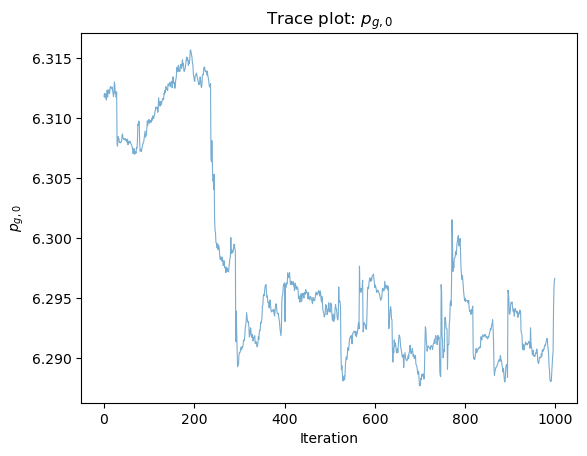

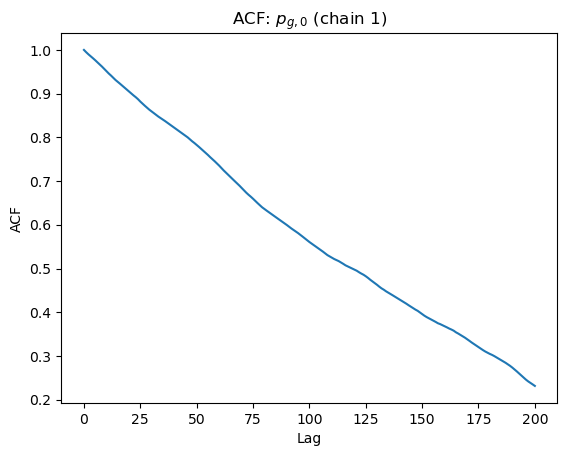

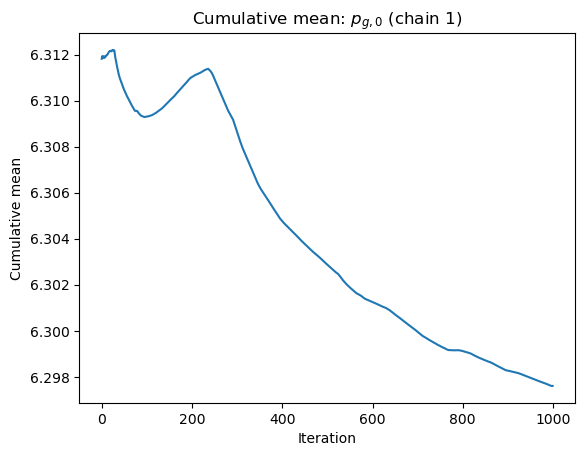

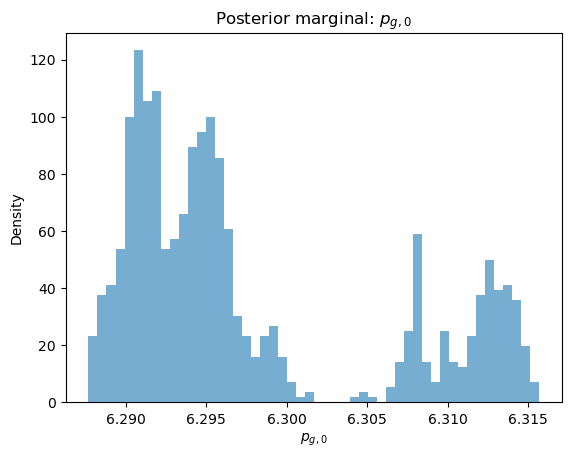

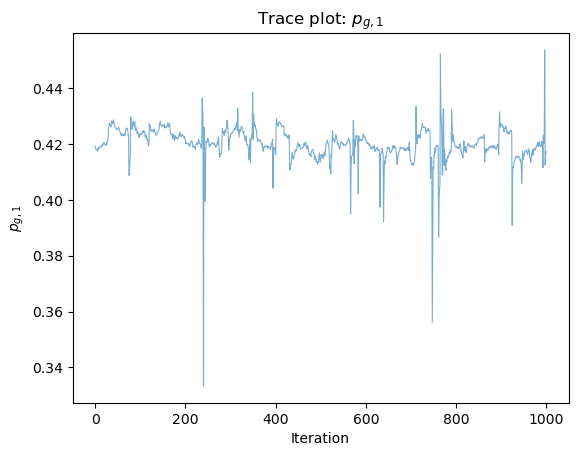

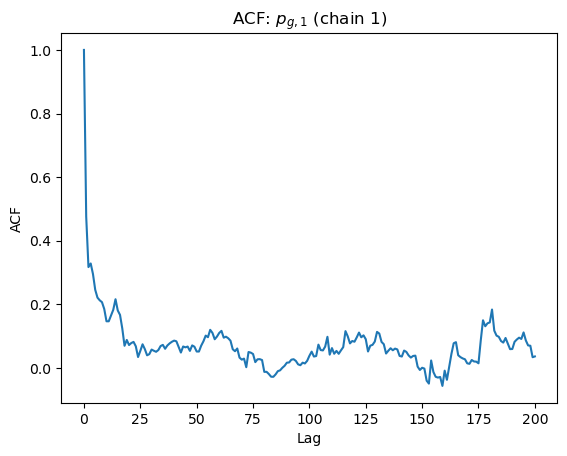

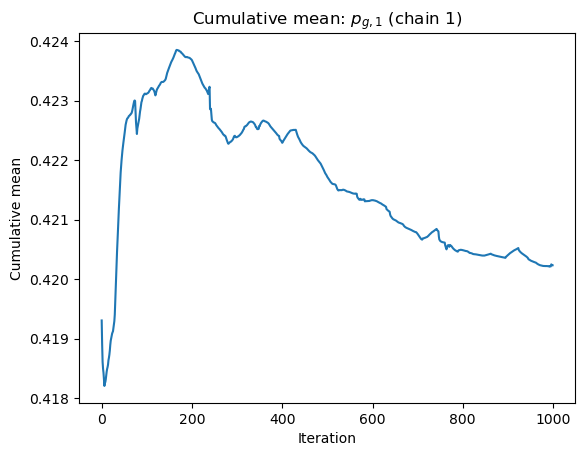

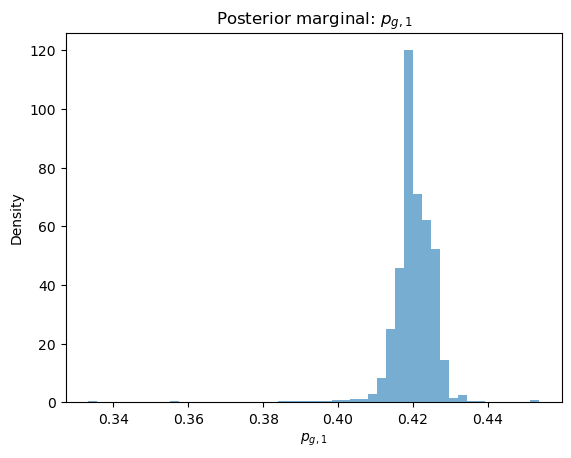

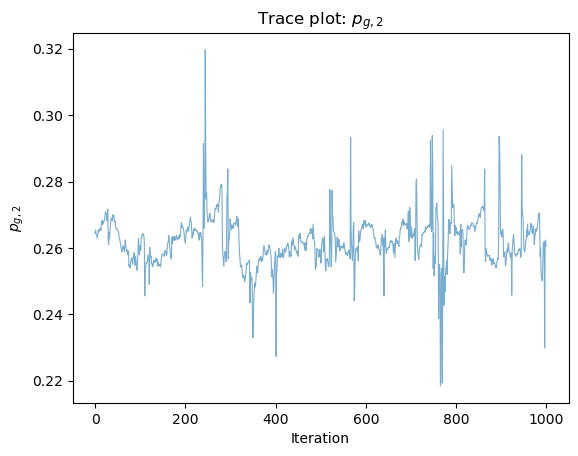

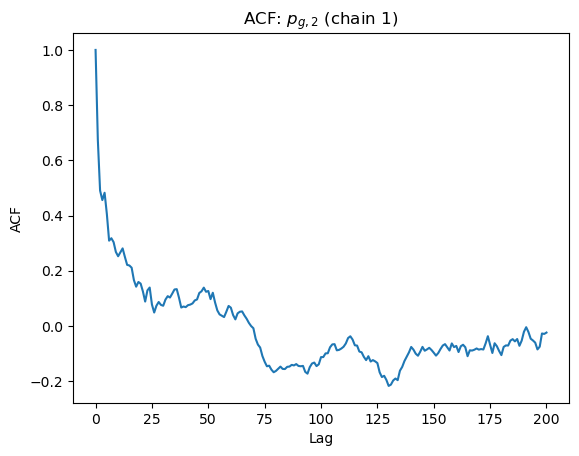

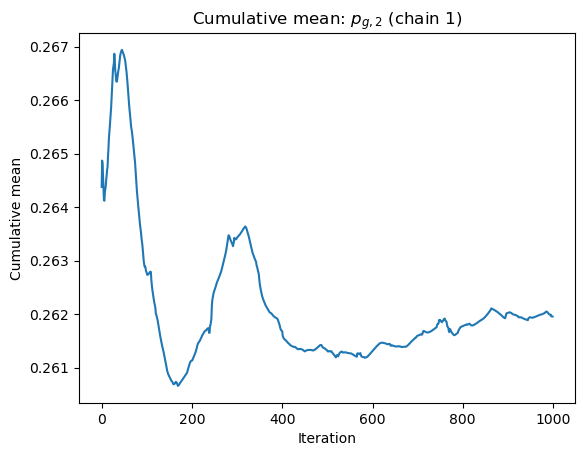

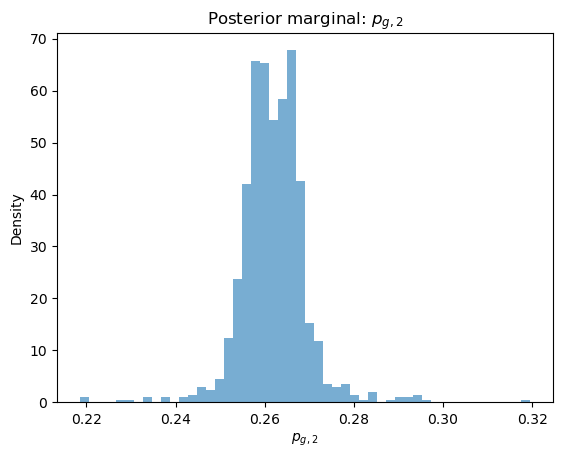

{'$p_{g,0}$': {'ESS_min': 4.026316510592466,
  'ESS_median': 4.026316510592466,
  'Rhat_split': 1.546070349362697},
 '$p_{g,1}$': {'ESS_min': 59.69919860247909,
  'ESS_median': 59.69919860247909,
  'Rhat_split': 1.0583577698435032},
 '$p_{g,2}$': {'ESS_min': 47.79548839570483,
  'ESS_median': 47.79548839570483,
  'Rhat_split': 1.0062419344992177},
 '$p_{g,3}$': {'ESS_min': 231.24123547234296,
  'ESS_median': 231.24123547234296,
  'Rhat_split': 0.999365483915183}}

In [7]:
diagnostics(gain_samples[0].reshape(1, 1000, 4), param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"])